In [132]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from tqdm import tqdm
from pathlib import Path
import random


import pandas as pd
from matplotlib import colors
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

sns.set_theme(style="darkgrid")


In [2]:
hands_path = 'Dataset/Training-Dataset/Images/'
masks_path = 'Dataset/Training-Dataset/Masks-Ideal/'

hands_files = Path(hands_path).glob('*.jpg')
masks_files = Path(masks_path).glob('*.bmp')

masks_file_names = []
hands_file_names = []

for file in hands_files: 
    hands_file_names.append(file.name)
    
for file in masks_files: 
    masks_file_names.append(file.name)

In [3]:
# Comprobamos que coincidan los archivos
hands_file_names.sort()
masks_file_names.sort()

print(hands_file_names[:5])
print(30*"-")
print(masks_file_names[:5])

print( len(hands_file_names), len(masks_file_names))

['0_A_hgr2B_id01_1.jpg', '0_A_hgr2B_id02_1.jpg', '0_A_hgr2B_id03_1.jpg', '0_A_hgr2B_id04_1.jpg', '0_A_hgr2B_id05_1.jpg']
------------------------------
['0_A_hgr2B_id01_1.bmp', '0_A_hgr2B_id02_1.bmp', '0_A_hgr2B_id03_1.bmp', '0_A_hgr2B_id04_1.bmp', '0_A_hgr2B_id05_1.bmp']
101 101


In [153]:
hand_images = []
for pathImg in hands_file_names:
  image = cv.imread(hands_path+pathImg)

  # convert from BGR to yCbCr colorspace for easier classification later
  image = cv.cvtColor(image, cv.COLOR_BGR2YCrCb)
  hand_images.append(image)

mask_images = []
for pathImg in masks_file_names:
  mask = cv.imread(masks_path+pathImg)
  mask_images.append(mask)

In [154]:
# Normalizamos los valores de la imagen original y de la máscara entre 0 y 1
for i in range(len(hand_images)):
  mask, g, r = cv.split(mask_images[i])
  # hand_images[i] = hand_images[i].astype('float32')
  hand_images[i] = np.array(hand_images[i], dtype=np.float32)
  mask_images[i] = mask.astype('float32') / 255


In [155]:
maxCr = []
minCr = []
maxCb = []
minCb = []
skin = []

columns=["Y", "Cr", "Cb"]
for i in tqdm(range(len(hand_images))):
    w, h, d = original_shape = tuple(hand_images[i].shape)  # Get the current shape
    w_, h_ = tuple(mask_images[i].shape)  # Get the current shape
    image_array = np.reshape(hand_images[i], (w * h, d))  # Reshape to to 2D
    mask_array_inv = np.reshape(mask_images[i], (w_ * h_, 1))  # Reshape to to 2D
    mask_array = mask_array_inv*-1+1

    pixels = pd.DataFrame(image_array, columns=columns)
    pixels["mask"] = mask_array

    mask_pixels = pixels[pixels["mask"]==1.0]

    maxCr.append(max(mask_pixels["Cr"]))
    minCr.append(min(mask_pixels["Cr"]))
    maxCb.append(max(mask_pixels["Cb"]))
    minCb.append(min(mask_pixels["Cb"]))
    skin.append(1)

    skin_pixels = pixels[pixels["mask"]==0.0]
    maxCr.append(max(skin_pixels["Cr"]))
    minCr.append(min(skin_pixels["Cr"]))
    maxCb.append(max(skin_pixels["Cb"]))
    minCb.append(min(skin_pixels["Cb"]))
    skin.append(0)




100%|██████████| 101/101 [00:07<00:00, 14.07it/s]


In [156]:
data = {
    'maxCr': maxCr,
    'minCr': minCr,
    'maxCb': maxCb,
    'minCb': minCb,
    'skin': skin
}

df = pd.DataFrame(data)


In [151]:
df.head()

,maxCr,minCr,maxCb,minCb,skin
0,160.0,128.0,164.0,129.0,1
1,138.0,118.0,149.0,124.0,0
2,151.0,118.0,161.0,129.0,1
3,132.0,110.0,144.0,126.0,0
4,150.0,99.0,157.0,117.0,1


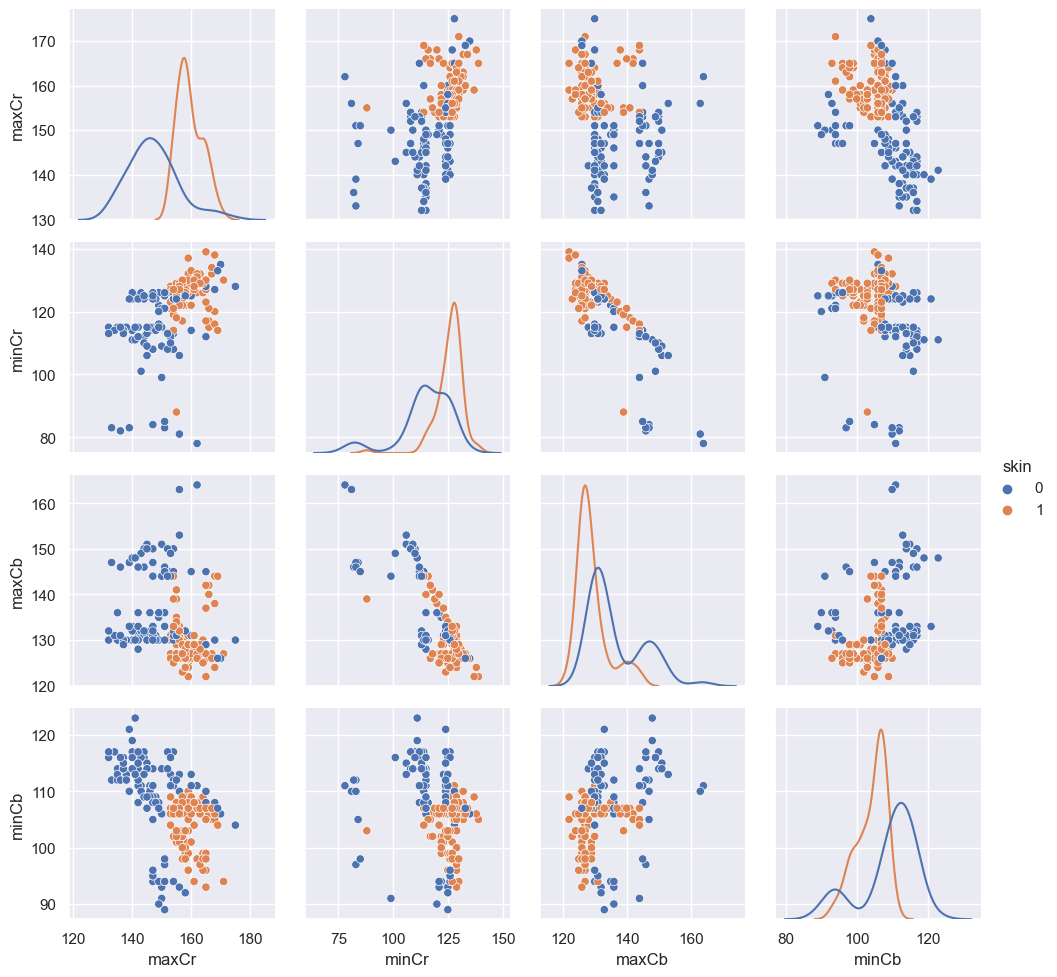

In [157]:
g = sns.PairGrid(df, hue="skin")
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
# g.map_diag(sns.kdeplot, lw=3, legend=False)


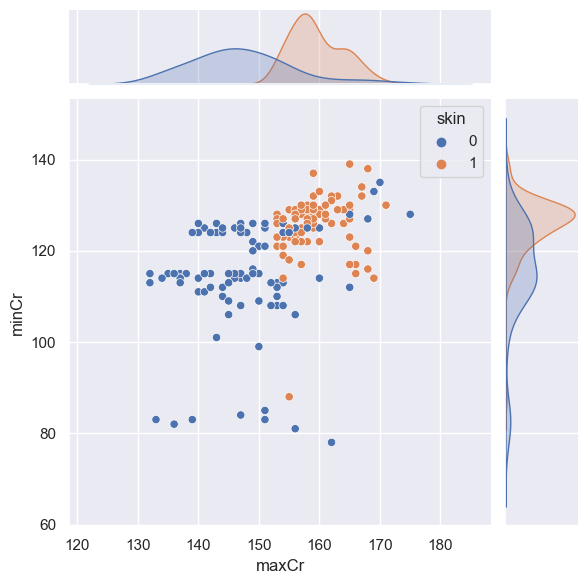

In [146]:
sns.jointplot(data=df, x="maxCr", y="minCr", hue="skin")
